In [1]:
from keras.utils import normalize
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import sys
import time

from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [2]:
"""Load data"""
sys.path.extend(['..'])
from data.adv_data_generator import ImageLoader

file = ["train"]
type_mod = ["img","mask","aug"]
dataset_aug = [[],[],[]]
num = 0
for i in file:
    for j in type_mod:
        loader = ImageLoader(i, j)
        dataset_aug[num] = loader.loadAug()
        num += 1

train_img= dataset_aug[0]
train_mask = dataset_aug[1]
train_aug = dataset_aug[2]

In [3]:
sys.path.extend(['..'])
from data.adv_data_generator import ImageLoader

file = ["val","test"]
type_mod = ["images","masks"]
dataset = [[],[],[],[]]
num = 0
for i in file:
    for j in type_mod:
        loader = ImageLoader(i, j)
        dataset[num] = loader.loadData()
        num += 1

val_img= dataset[0]
val_mask = dataset[1]
test_img = dataset[2]
test_mask = dataset[3]

In [4]:
import random

'''
(1) Set the seed
(2) Generate a random permutation of indices
(3) Use the same random indices for sampling both arrays
'''

def sampling(img, mask, seed, percentage=0.2):
    sample_size = int(len(img) * percentage)
    random.seed(seed)
    random_indices = random.sample(range(len(img)), sample_size)
    sample_img = img[random_indices]
    sample_mask = mask[random_indices]

    return sample_img, sample_mask

sam_val_img, sam_val_mask = sampling(val_img, val_mask, 4)
sam_test_img, sam_test_mask = sampling(test_img, test_mask, 7)

print(sam_val_mask.shape[0])
print(sam_test_mask.shape[0])
print(np.unique(sam_val_mask))

6415
6415
[0 1 2 3 4 5 6 7]


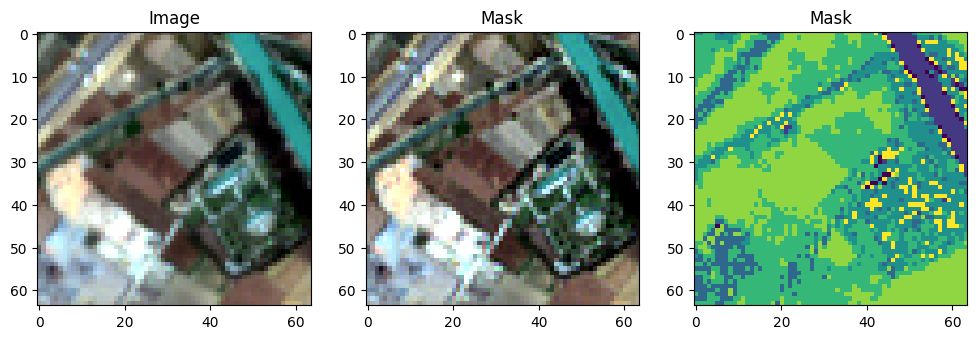

In [40]:
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(train_img[1112])
plt.title('Image')
plt.subplot(132)
plt.imshow(train_aug[1112])
plt.title('Mask')
plt.subplot(133)
plt.imshow(train_mask[1112])
plt.title('Mask')
plt.show()

In [5]:
'''Define variable to run the model'''
# X = np.concatenate((mod_train_img, mod_train_aug), axis=0)
# y = np.concatenate((mod_train_mask, mod_train_mask), axis=0)
X, y = train_img, train_mask
X_val = sam_val_img
y_val = sam_val_mask

In [6]:
n_classes = 8
from keras.utils import to_categorical
y_cat = to_categorical(y, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation

In [8]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer

class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
#         print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = tf.cast(argmax, K.floatx())
        return [output, argmax]
    
    def compute_output_shape(self, input_shape):
#         print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

In [9]:
class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        mask = tf.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')

        #  calculation new shape
        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1]*self.size[0],
                input_shape[2]*self.size[1],
                input_shape[3])
        self.output_shape1 = output_shape

        # calculation indices for batch, height, width and feature maps
        one_like_mask = tf.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
        batch_shape = tf.concat([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = tf.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
        b = one_like_mask * batch_range

        y = mask // (output_shape[2] * output_shape[3])

        x = (mask // output_shape[3]) % output_shape[2]

        feature_range = tf.range(output_shape[3], dtype='int32')

        f = one_like_mask * feature_range

        # transpose indices & reshape update values to one dimension
        updates_size = tf.size(updates)       # Prints the number of elements in the updates
        indices = tf.transpose(tf.reshape(tf.stack([b, y, x, f]), [4, updates_size]))
        values = tf.reshape(updates, [updates_size])
        ret = tf.scatter_nd(indices, values, output_shape)
        return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [15]:
def usegnet_model_base(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, pool_size=(2, 2)):

    # encoder 
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) 
    
    conv_1 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs) 
    conv_1 = Activation("relu")(conv_1)
    conv_1 = BatchNormalization()(conv_1) 
    conv_2 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1) 
    conv_2 = Activation("relu")(conv_2)
    conv_2 = BatchNormalization()(conv_2)
    
    pool_1 = MaxPooling2D(pool_size, name="block1_pool")(conv_2)
    
    conv_3 = Conv2D(128, (3, 3), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = Activation("relu")(conv_3)
    conv_3 = BatchNormalization()(conv_3)
    conv_4 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = Activation("relu")(conv_4)
    conv_4 = BatchNormalization()(conv_4)
    
    pool_2 = MaxPooling2D(pool_size, name="block2_pool")(conv_4)
    
    conv_5 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = Activation("relu")(conv_5)
    conv_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = Activation("relu")(conv_6)
    conv_6 = BatchNormalization()(conv_6)
    conv_7 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = Activation("relu")(conv_7)
    conv_7 = BatchNormalization()(conv_7)
    
    pool_3 = MaxPooling2D(pool_size, name="block3_pool")(conv_7)
    
    #bottleneck
    conv_13 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(pool_3)
    conv_13 = Activation("relu")(conv_13)
    conv_13 = BatchNormalization()(conv_13)
       
    #decoder
    unpool_1 = UpSampling2D((pool_size))(conv_13)
    
    conv_14 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = Activation("relu")(conv_14)
    conv_14 = BatchNormalization()(conv_14)
    conv_15 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = Activation("relu")(conv_15)
    conv_15 = BatchNormalization()(conv_15)
    conv_16 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = Activation("relu")(conv_16)
    conv_16 = BatchNormalization()(conv_16)
    
    unpool_2 = UpSampling2D((pool_size))(conv_16)
    
    conv_17 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = Activation("relu")(conv_17)
    conv_17 = BatchNormalization()(conv_17)
    conv_18 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = Activation("relu")(conv_18)
    conv_18 = BatchNormalization()(conv_18)
    
    unpool_3 = UpSampling2D((pool_size))(conv_18)
    
    #concatenation (unpool_4, conv_2)
    merge = concatenate([unpool_3,conv_2], axis = -1)
    
    conv_19 = Conv2D(64, (1, 1), padding="same", kernel_initializer='he_normal')(merge)
    conv_19 = Activation("relu")(conv_19)
    conv_19 = BatchNormalization()(conv_19)
    
    conv_20 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_19)
    conv_20 = Activation("relu")(conv_20)
    conv_20 = BatchNormalization()(conv_20)
    
    conv_21 = Conv2D(n_classes, (1, 1), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)

    outputs = Activation("softmax")(conv_21)
         
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [11]:
from keras.callbacks import ModelCheckpoint, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='model_usegnet_default_checkpoint.weights.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=5, verbose=1)
rd = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [tb, mc, es, rd]

In [12]:
IMG_HEIGHT = X.shape[1]
IMG_WIDTH  = X.shape[2]
IMG_CHANNELS = X.shape[3]

In [18]:
from keras.optimizers import SGD

def get_model():
    # Create the model
    model = usegnet_model_base(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
    
    # Compile the model with custom optimizer
    optimizer = SGD(learning_rate=0.001, momentum =0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', sm.metrics.iou_score])
    
    return model

In [19]:
model = get_model()
# model.summary()

In [20]:
start_time = time.time()
history = model.fit(X, y_cat, 
                    batch_size = 64, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_val, y_val_cat),
                    callbacks = callbacks,
                    shuffle=False)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.4f} seconds")

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3328 - iou_score: 0.0722 - loss: 1.8966
Epoch 1: accuracy improved from -inf to 0.46288, saving model to model_usegnet_default_checkpoint.weights.h5
468/468 ━━━━━━━━━━━━━━━━━━━━ 1202s 3s/step - accuracy: 0.3330 - iou_score: 0.0722 - loss: 1.8959 - val_accuracy: 0.5863 - val_iou_score: 0.1166 - val_loss: 1.2598 - learning_rate: 0.0010
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6071 - iou_score: 0.1233 - loss: 1.1654
Epoch 2: accuracy improved from 0.46288 to 0.61891, saving model to model_usegnet_default_checkpoint.weights.h5
468/468 ━━━━━━━━━━━━━━━━━━━━ 1196s 3s/step - accuracy: 0.6072 - iou_score: 0.1233 - loss: 1.1653 - val_accuracy: 0.6380 - val_iou_score: 0.1417 - val_loss: 1.0249 - learning_rate: 0.0010
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6368 - iou_score: 0.1444 - loss: 1.0119
Epoch 3: accuracy improved from 0.61891 to 0.64192, saving model to model_usegnet_default_

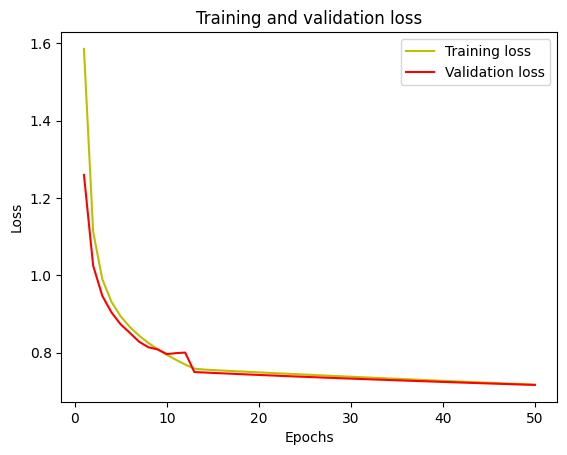

In [21]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

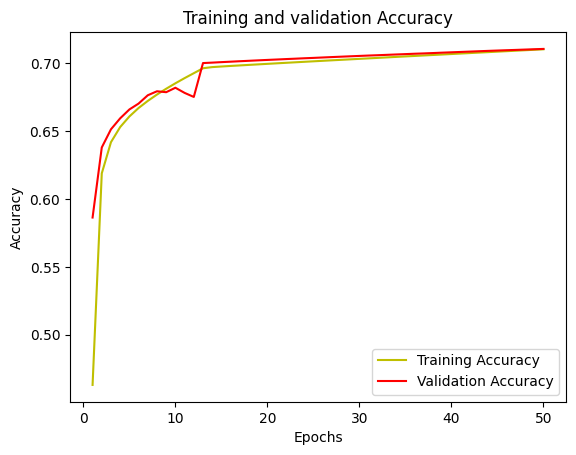

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
Xtest, ytest = sam_test_img, sam_test_mask

In [24]:
Ytest_cat = to_categorical(ytest, num_classes=n_classes)

In [ ]:
# Evaluasi model
loss, accuracy, iou_score = model.evaluate(Xtest, Ytest_cat)
print(accuracy)
print(iou_score)

In [25]:
# Predict and evaluate
y_pred = model.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = ytest

201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 276ms/step


In [26]:
# Flatten the arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

In [27]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_flat, y_pred_flat, target_names=['Class 0', 
                                                                       'Class 1', 
                                                                       'Class 2', 
                                                                       'Class 3', 
                                                                       'Class 4', 
                                                                       'Class 5', 
                                                                       'Class 6', 
                                                                       'Class 8'])
print(report)

C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         8
     Class 1       0.43      0.04      0.07    293759
     Class 2       0.37      0.16      0.22    324962
     Class 3       0.37      0.14      0.21   1487533
     Class 4       0.50      0.59      0.55   2862958
     Class 5       0.60      0.72      0.65   7413470
     Class 6       0.88      0.87      0.87  12772966
     Class 8       0.36      0.24      0.28   1120184

    accuracy                           0.71  26275840
   macro avg       0.44      0.34      0.36  26275840
weighted avg       0.70      0.71      0.70  26275840



C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
#IOU

n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ytest, y_pred_classes)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.26018974


In [41]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 64, 64, 64)        │           1,792 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_23 (Activation)    │ (None, 64, 64, 64)        │               0 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_23        │ (None, 64, 64, 64)        │             256 │ activation_23[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 64, 64, 64)        │          36,928 │ batch_normalization_23[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_24 (Activation)    │ (None, 64, 64, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_24        │ (None, 64, 64, 64)        │             256 │ activation_24[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 32, 32, 64)        │               0 │ batch_normalization_24[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 32, 32, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_25 (Activation)    │ (None, 32, 32, 128)       │               0 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_25        │ (None, 32, 32, 128)       │             512 │ activation_25[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 32, 32, 128)       │         147,584 │ batch_normalization_25[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_26 (Activation)    │ (None, 32, 32, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_26        │ (None, 32, 32, 128)       │             512 │ activation_26[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 16, 16, 128)       │               0 │ batch_normalization_26[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,149,954 (31.09 MB)

 Trainable params: 4,072,600 (15.54 MB)

 Non-trainable params: 4,752 (18.56 KB)

 Optimizer params: 4,072,602 (15.54 MB)